In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Tutorial:　https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
import geopandas as gpd

In [3]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
import json

In [4]:
# Source = https://data.gov.tw/dataset/7442 直轄市、縣市界線(TWD97經緯度)
tw = "mapdata/COUNTY_MOI_1080726.shp"
map_tw = gpd.read_file(tw, encoding="utf-8")

In [5]:
map_tw.head(10)

,COUNTYID,COUNTYCODE,COUNTYNAME,COUNTYENG,geometry
0,Z,09007,連江縣,Lienchiang County,(POLYGON ((119.9644519140001 25.94552317400007...
1,G,10002,宜蘭縣,Yilan County,(POLYGON ((121.9597084550001 24.84493697000005...
2,N,10007,彰化縣,Changhua County,"POLYGON ((120.4565526600001 24.20718620500008,..."
3,M,10008,南投縣,Nantou County,"POLYGON ((121.2708644380001 24.23660985400005,..."
4,P,10009,雲林縣,Yunlin County,"(POLYGON ((120.081077282 23.52412216400006, 12..."
5,T,10013,屏東縣,Pingtung County,"(POLYGON ((120.379645899 22.35598933400007, 12..."
6,X,10016,澎湖縣,Penghu County,(POLYGON ((119.4402533230001 23.22136844000005...
7,C,10017,基隆市,Keelung City,"(POLYGON ((121.710150286 25.17604204900005, 12..."
8,O,10018,新竹市,Hsinchu City,"POLYGON ((120.9301072960001 24.85301711800008,..."
9,A,63000,臺北市,Taipei City,"POLYGON ((121.5709805050001 25.19716811600006,..."


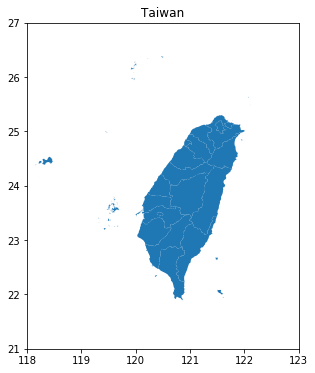

In [8]:
fig, ax = plt.subplots(figsize=(14,6))
map_tw.plot(ax=ax)
ax.set(title="Taiwan")
ax.set_ylim(21,27)
ax.set_xlim(118,123)
plt.show()

In [11]:
# Source: https://gis.ris.gov.tw/dashboard.html?key=B01
demo = pd.read_csv("mapdata/population.csv")
demo = demo.rename(columns={"區域別": "COUNTYNAME", "總計":"population"})
demo['population'] = demo['population'].str.replace(',', '').astype(int)

In [12]:
demo = demo.replace(['臺北縣', '桃園縣'], ['新北市', '桃園市'])
demo.loc[demo.COUNTYNAME == '臺中市','population'] += demo.loc[demo.COUNTYNAME == '臺中縣','population'].values[0]
demo.loc[demo.COUNTYNAME == '臺南市','population'] += demo.loc[demo.COUNTYNAME == '臺南縣','population'].values[0]
demo.loc[demo.COUNTYNAME == '高雄市','population'] += demo.loc[demo.COUNTYNAME == '高雄縣','population'].values[0]

In [18]:
demo = demo[(demo.COUNTYNAME != '臺中縣') & (demo.COUNTYNAME != '臺南縣') & (demo.COUNTYNAME != '高雄縣') & (demo.COUNTYNAME != '總計')]

In [13]:
demo.head()

,COUNTYNAME,population
0,臺北市,2632010
1,高雄市,2731082
2,新北市,3614389
3,宜蘭縣,466230
4,桃園市,1766106


In [19]:
merged = pd.merge(map_tw, demo, on='COUNTYNAME', how='outer')

In [20]:
pop_sum = merged.population.sum()
merged['percentage'] = merged['population'] / pop_sum * 100

In [21]:
merged.head()

,COUNTYID,COUNTYCODE,COUNTYNAME,COUNTYENG,geometry,population,percentage
0,Z,09007,連江縣,Lienchiang County,(POLYGON ((119.9644519140001 25.94552317400007...,9569,0.042677
1,G,10002,宜蘭縣,Yilan County,(POLYGON ((121.9597084550001 24.84493697000005...,466230,2.079361
2,N,10007,彰化縣,Changhua County,"POLYGON ((120.4565526600001 24.20718620500008,...",1315034,5.864981
3,M,10008,南投縣,Nantou County,"POLYGON ((121.2708644380001 24.23660985400005,...",542181,2.418098
4,P,10009,雲林縣,Yunlin County,"(POLYGON ((120.081077282 23.52412216400006, 12...",744830,3.321902


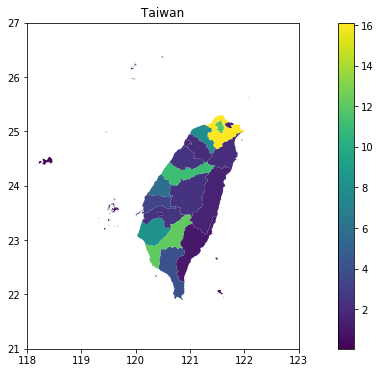

In [22]:
fig, ax = plt.subplots(figsize=(14,6))
merged.plot(ax=ax, column = 'percentage', legend=True)
ax.set(title="Taiwan")
ax.set_ylim(21,27)
ax.set_xlim(118,123)
plt.show()

In [24]:
#Read data to json.
merged_json = json.loads(merged.to_json())
#Convert to String like object.
json_data = json.dumps(merged_json)

In [25]:
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data)

In [26]:
# Create figure object
p = figure(title = 'Taiwan Demographic in 2002', plot_height = 600 , plot_width = 950, toolbar_location = None)

In [27]:
# Add patches renderer
p.patches('xs','ys', source = geosource, line_color = 'black')

GlyphRenderer(id='1039', ...)

In [28]:
output_file('taiwan.html', title = 'Taiwan Demographic 2002') # render to static html

In [29]:
show(p)